## Data Cleaning ##

**Imports for Data Importing/Exploring**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

In [2]:
#reading in csv file
df = pd.read_csv('./csv_files/comms_orginal.csv')

In [3]:
#displaying first three rows
df.head(3)

,subreddit,author,body,created_utc
0,dndnext,DMPatrick,"Well first of all, if that's the only way you ...",1635356097
1,dndnext,whitetempest521,The feat is where almost the entire power budg...,1635356068
2,dndnext,Th1nker26,Oh I don't think it's a problem. I thought the...,1635356043


In [4]:
#dropping 'created_utc' 
df.drop(['created_utc'], axis = 1, inplace = True)

In [5]:
#confirming value_counts for subreddit is evenly split
df['subreddit'].value_counts()

dndnext      20000
DMAcademy    19999
Name: subreddit, dtype: int64

In [6]:
#checking to see if classes still balanced
df['subreddit'].value_counts(normalize = True)

dndnext      0.500013
DMAcademy    0.499987
Name: subreddit, dtype: float64

In [7]:
#checking for null values
df.isna().sum().sort_values(ascending = False)

subreddit    0
author       0
body         0
dtype: int64

In [8]:
#setting our target 'subreddit' to map values to 0 and 1:
df['subreddit'] = df['subreddit'].map({'dndnext': 0,
                                       'DMAcademy': 1})

In [9]:
df.head(3)

,subreddit,author,body
0,0,DMPatrick,"Well first of all, if that's the only way you ..."
1,0,whitetempest521,The feat is where almost the entire power budg...
2,0,Th1nker26,Oh I don't think it's a problem. I thought the...


In [10]:
#checking the data types of columns:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39999 entries, 0 to 39998
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  39999 non-null  int64 
 1   author     39999 non-null  object
 2   body       39999 non-null  object
dtypes: int64(1), object(2)
memory usage: 937.6+ KB


In [11]:
#checking instances of duplicated comments:
df['body'].duplicated().sum()

797

In [12]:
#taking a quick look at author counts for my own sake
df['author'].value_counts().sort_values(ascending = False)

#use later to see if subreddit mods drive comments?

[deleted]              599
lasalle202             218
Cpt_Tsundere_Sharks    176
Ishigami-the-Kami      120
ReturnToFroggee        117
                      ... 
seraosha                 1
ThePotatoMuffin347       1
Count_Backwards          1
ProfNesbitt              1
bigmyq                   1
Name: author, Length: 12143, dtype: int64

In [13]:
#looking at the instances of duplicated comments:

#https://stackoverflow.com/questions/14657241/how-do-i-get-a-list-of-all-the-duplicate-items-using-pandas-in-python
dups_df = pd.concat(g for _, g in df.groupby('body') if len(g) > 1)
dups_df

#some instances of repeat/dup posts are individuals posting the same post on each of the two subreddits,
#is that truly dup? Looking at these posts I'm going to keep the dups with the exception of the posts
#'[removed]'

,subreddit,author,body
2801,0,BlackAceX13,&gt; Where WOTC arbitrarily threw out balance ...
2802,0,BlackAceX13,&gt; Where WOTC arbitrarily threw out balance ...
12049,0,WikiSummarizerBot,**[Tom Stoltman](https://en.wikipedia.org/wiki...
12054,0,WikiSummarizerBot,**[Tom Stoltman](https://en.wikipedia.org/wiki...
4337,0,AwsmDevil,*oh my god*
...,...,...,...
31153,1,Jordy_Rabitart,thanks!
31157,1,Jordy_Rabitart,thanks!
31167,1,Jordy_Rabitart,thanks!
11389,0,Sten4321,you can switch you the proficiencies of backgr...


In [14]:
#looking at the top ten most frequent duplicates:
dups_df['body'].value_counts()[:10]

[deleted]     497
[removed]      82
Thank you!     21
Thank you.     15
Thanks!        12
No             11
Yes            10
Yes.           10
Thanks          7
Thanks.         5
Name: body, dtype: int64

In [15]:
#deleting instances of [deleted] and [removed]:
df.loc[df['body'] == '[deleted]'].head(3)

,subreddit,author,body
68,0,[deleted],[deleted]
181,0,[deleted],[deleted]
215,0,[deleted],[deleted]


In [16]:
df.loc[df['body'] == '[removed]'].head(3)

,subreddit,author,body
2661,0,[deleted],[removed]
2849,0,[deleted],[removed]
3158,0,[deleted],[removed]


In [17]:
#cleaner way to remove duplicates:
df = df[df.body != '[deleted]']
df = df[df.body != '[removed]']
df = df[df.body != 'Thank you!']
df = df[df.body != 'Thank you.']
df = df[df.body != 'Thanks!']

df['body'].value_counts()[:5]

No                11
Yes.              10
Yes               10
Thanks             7
I participate!     5
Name: body, dtype: int64

In [18]:
df.shape

(39372, 3)

**Sentiment Analysis**

In [19]:
#imports for sentiment analysis

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [20]:
#taking a look at the first post:
df['body'][0]

#It appears it will be hard to analyze, lots of 'good' and 'bad' words

"Well first of all, if that's the only way you find enjoyment then that's okay. You can play all of your characters that way if that's how you have fun.\n\nBut a few thoughts and suggestions that might help... \n\nFill out the traits, bonds, flaws, and ideals on your character sheets and refer back to them regularly.  If you're playing a character who shoots first and asks questions later, write that down! It helps to have some writen words to keep you in character.\n\nPerhaps a moot suggestion but try using a voice or accent. This will help mentally separate the character you're acting as from the real person you are. \n\nYou mention not wanting to feel evil a few times. But evil is subjective"

In [21]:
sia = SentimentIntensityAnalyzer()

In [22]:
#https://data-science-blog.com/en/blog/2018/11/04/sentiment-analysis-using-python/
def sentiment(x):
    return text(x).sentiment  

#From link:
#"As it can be observed there are two scores: the first score is sentiment
#polarity which tells if the sentiment is positive or negative and the
#second score is subjectivity score to tell how subjective is the text."

In [23]:
#for slide presentation:
sia.polarity_scores('Our party viciously slaughtered the gang of evil goblins harming the village')

{'neg': 0.49, 'neu': 0.381, 'pos': 0.129, 'compound': -0.8225}

In [24]:
#building an array of polarity scores to make into a dataframe:
scores = []
for comment in df['body']:
    current_scores = sia.polarity_scores(comment)
    scores.append(current_scores)

In [25]:
#making to polarity scores dataframe:
scores_df = pd.DataFrame(scores)

In [26]:
scores_df.head(3)

,neg,neu,pos,compound
0,0.086,0.768,0.146,0.3802
1,0.034,0.934,0.032,-0.0657
2,0.078,0.793,0.129,0.0611


In [27]:
#concating scores with the comment to give frame of reference
polarity_df = pd.concat([df, scores_df], axis = 1)
polarity_df.drop(columns = ['author'], inplace = True)

In [28]:
polarity_df.head(3)

,subreddit,body,neg,neu,pos,compound
0,0.0,"Well first of all, if that's the only way you ...",0.086,0.768,0.146,0.3802
1,0.0,The feat is where almost the entire power budg...,0.034,0.934,0.032,-0.0657
2,0.0,Oh I don't think it's a problem. I thought the...,0.078,0.793,0.129,0.0611


Sentiment for 'dndnext':

In [29]:
#sentiment scores for the 'dndnext' subreddit:
polarity_df[polarity_df['subreddit'] == 0].sort_values(by = 'compound', ascending = False).head(5)

,subreddit,body,neg,neu,pos,compound
1058,0.0,Seriously. Any character should be able to do ...,0.037,0.749,0.214,0.9991
8913,0.0,Samesies actually. It's cool to see other dnd ...,0.116,0.687,0.197,0.9989
4348,0.0,I am an Eberron fan. The creator of the settin...,0.083,0.651,0.266,0.9987
8077,0.0,Obviously this isn’t how you build a good myst...,0.072,0.717,0.211,0.9985
10993,0.0,"Mercy monk is fine. It's healing, like all hea...",0.074,0.692,0.234,0.9984


In [30]:
polarity_df[polarity_df['subreddit'] == 0].sort_values(by = 'neg', ascending = False).head(5)

,subreddit,body,neg,neu,pos,compound
132,0.0,&gt; I'm not level 10 yet but you only get two...,1.0,0.0,0.0,-0.2960
19449,0.0,wanting to succeed rolls automatically sounds ...,1.0,0.0,0.0,-0.2732
16907,0.0,...it's been that way with physical CDs for ov...,1.0,0.0,0.0,-0.2960
8383,0.0,"If it's combat heavy max con second, take thou...",1.0,0.0,0.0,-0.2960
13130,0.0,That is not a CR 18 encounter. It seems that t...,1.0,0.0,0.0,-0.4019


In [31]:
polarity_df[polarity_df['subreddit'] == 0].sort_values(by = 'pos', ascending = False).head(5)

,subreddit,body,neg,neu,pos,compound
15547,0.0,I think their should be a kind of Blood Mage c...,0.0,0.0,1.0,0.4019
10535,0.0,"At the very least, you want the core idea, som...",0.0,0.0,1.0,0.4019
11051,0.0,Generally the absolute top choice for a level ...,0.0,0.0,1.0,0.4404
8180,0.0,"Project manager at a translation company here,...",0.0,0.0,1.0,0.4215
16861,0.0,This right here. I hate Amazon as much as the ...,0.0,0.0,1.0,0.6476


Sentiment for 'dmacademy':

In [32]:
#sentiment scores for the 'dmacademy' subreddit:
polarity_df[polarity_df['subreddit'] == 1].sort_values(by = 'compound', ascending = False).head(5)

,subreddit,body,neg,neu,pos,compound
33925,1.0,Your goblin is going to be slightly less of a ...,0.045,0.711,0.244,0.9996
24573,1.0,How its flavoured doesn't really matter whethe...,0.079,0.736,0.185,0.9994
34981,1.0,"IDK, but kudos on the DM points. I've always w...",0.069,0.734,0.196,0.9993
30911,1.0,"For people with ADHD, sometimes doing another ...",0.059,0.751,0.190,0.9993
27192,1.0,"- with players not following up on leads, don'...",0.070,0.731,0.199,0.9991


In [33]:
polarity_df[polarity_df['subreddit'] == 1].sort_values(by = 'neg', ascending = False).head(5)

,subreddit,body,neg,neu,pos,compound
24237,1.0,"Your welcome, if they insist on damage you can...",1.0,0.0,0.0,-0.6360
24061,1.0,"The spell version of ""Flaming Raging Poisoning...",1.0,0.0,0.0,-0.1027
29649,1.0,&gt;I think those are the same question though...,1.0,0.0,0.0,-0.6808
37497,1.0,I saw in another comment that he's actually go...,1.0,0.0,0.0,-0.2960
36163,1.0,I like this enough that I may steal it. I thi...,1.0,0.0,0.0,-0.2960


In [34]:
polarity_df[polarity_df['subreddit'] == 1].sort_values(by = 'pos', ascending = False).head(5)

,subreddit,body,neg,neu,pos,compound
35549,1.0,Alright so [here](https://dnd.wizards.com/arti...,0.0,0.0,1.0,0.4404
27496,1.0,"If you’re virtual, just DM them cues they can ...",0.0,0.0,1.0,0.2732
26385,1.0,I would stamp a plot device to the noobie's fo...,0.0,0.0,1.0,0.4019
27410,1.0,If you're up for something incredibly silly yo...,0.0,0.0,1.0,0.7845
33720,1.0,"Also, drow live for centuries. It doesn't take...",0.0,0.0,1.0,0.4767


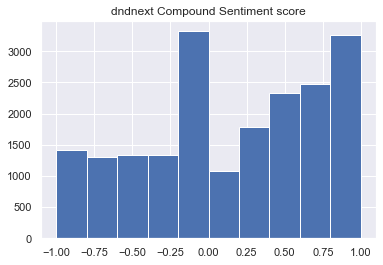

In [35]:
#dndnext sentiment histogram
polarity_df[polarity_df['subreddit'] == 0].hist(column = 'compound', )
plt.title('dndnext Compound Sentiment score');

In [36]:
#https://www.python-graph-gallery.com/25-histogram-with-several-variables-seaborn
#fig, axs = plt.subplots(3, 1, figsize=(7, 10))

#sns.histplot(data=polarity_df[polarity_df['subreddit'] == 0], x="neu", color="skyblue", label='Neutral', kde=True, ax=axs[0])
#sns.histplot(data=polarity_df[polarity_df['subreddit'] == 0], x="pos", color="gold", label='Positive', kde=True, ax=axs[1])
#sns.histplot(data=polarity_df[polarity_df['subreddit'] == 0], x="neg", color="red", label='Negative', kde=True, ax=axs[2])

#plt.legend() 
#plt.show()

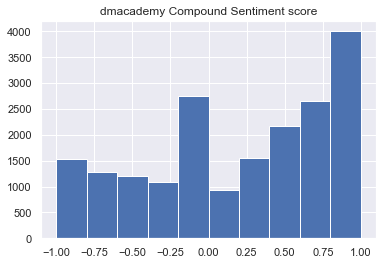

In [37]:
polarity_df[polarity_df['subreddit'] == 1].hist(column = 'compound')
plt.title('dmacademy Compound Sentiment score');

In [38]:
#https://www.python-graph-gallery.com/25-histogram-with-several-variables-seaborn
#fig, axs = plt.subplots(3, 1, figsize=(7, 10))

#sns.histplot(data=polarity_df[polarity_df['subreddit'] == 1], x="neu", color="skyblue", label='Neutral', kde=True, ax=axs[0])
#sns.histplot(data=polarity_df[polarity_df['subreddit'] == 1], x="pos", color="gold", label='Positive', kde=True, ax=axs[1])
#sns.histplot(data=polarity_df[polarity_df['subreddit'] == 1], x="neg", color="red", label='Negative', kde=True, ax=axs[2])

#plt.legend() 
#plt.show()

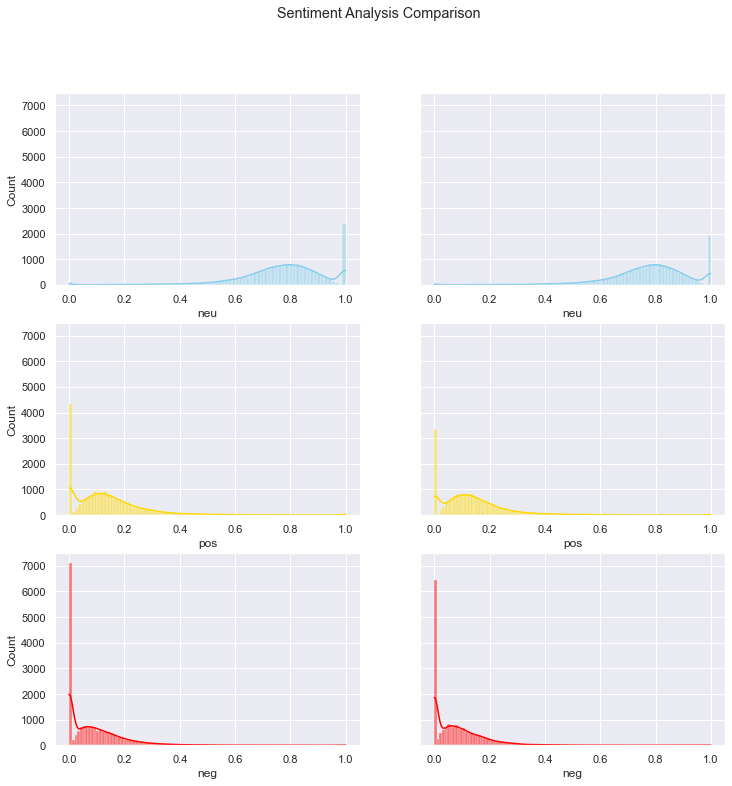

In [39]:
#https://www.python-graph-gallery.com/25-histogram-with-several-variables-seaborn
fig, axs = plt.subplots(3, 2, sharey=True, figsize=(12, 12))
fig.suptitle('Sentiment Analysis Comparison')

sns.histplot(data=polarity_df[polarity_df['subreddit'] == 0], x="neu", color="skyblue", label='Neutral', kde=True, ax=axs[0, 0])
sns.histplot(data=polarity_df[polarity_df['subreddit'] == 0], x="pos", color="gold", label='Positive', kde=True, ax=axs[1, 0])
sns.histplot(data=polarity_df[polarity_df['subreddit'] == 0], x="neg", color="red", label='Negative', kde=True, ax=axs[2, 0])

sns.histplot(data=polarity_df[polarity_df['subreddit'] == 1], x="neu", color="skyblue", label='Neutral', kde=True, ax=axs[0, 1])
sns.histplot(data=polarity_df[polarity_df['subreddit'] == 1], x="pos", color="gold", label='Positive', kde=True, ax=axs[1, 1])
sns.histplot(data=polarity_df[polarity_df['subreddit'] == 1], x="neg", color="red", label='Negative', kde=True, ax=axs[2, 1])

plt.show()

#bp.set_titles("{col_name}")
#bp.set_ylabels("Time (s)")
#bp.set_xlabels("Number")
#sns.plt.show()

**'body' Text Cleaning**

In [40]:
#https://stackoverflow.com/questions/50444346/fast-punctuation-removal-with-pandas
#https://stackoverflow.com/questions/4328500/how-can-i-strip-all-punctuation-from-a-string-in-javascript-using-regex
#https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
#https://regex101.com/
#https://stackoverflow.com/questions/336210/regular-expression-for-alphanumeric-and-underscores

import re
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [41]:
df[['body']]

,body
0,"Well first of all, if that's the only way you ..."
1,The feat is where almost the entire power budg...
2,Oh I don't think it's a problem. I thought the...
3,"Eh, not necessarily. DM screens can hide books..."
4,what other features should i remove in order t...
...,...
39994,"""Fuck off mate, who do you think you are invit..."
39995,Well then two possibilities : \n\neither every...
39996,RAW you need to hold the focus. And a focus do...
39997,I got into an argument with my players recentl...


In [42]:
#function to clean up the text in 'body':
def mrclean(text):
    
    #lowercase:
    text = text.lower()
    
    #fixing contractions (MUST DO THIS BEFORE SPECIAL CHAR REMOVAL)
    # specific
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)

    # general
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    
    #removing special characters, need to keep numbers for D&D stuff:
    text = re.sub('[^a-zA-Z0-9_]', ' ', text)
    
    #removing 1-, 2-letter words:
    text = re.sub(r'\b\w{1,2}\b', '', text)
    
    #removing odd instances of '/n'
    text = re.sub("\n", '', text)
    
    #trying to take care of spacing
    text = re.sub(r'/\s+/g', " ", text)
    
    return text

- I had trouble trying to strip special characters with string.punctuation and specifying punctuation like 'r/[.,\/#!\$%\^&\*;:{}=\-_`~()]/g',
I kept getting stuck with ellipses and instances of that', so I just opted to remove everything that wasn't a letter.

In [43]:
#putting mrclean to work:
df['body'] = df['body'].apply(mrclean)

In [44]:
#looking at cleaned dataframe:
df[['body']]

,body
0,well first all that the only way you find ...
1,the feat where almost the entire power budget...
2,not think problem thought the guy was ...
3,not necessarily screens can hide books and...
4,what other features should remove order bal...
...,...
39994,fuck off mate who you think you are invitin...
39995,well then two possibilities either everyon...
39996,raw you need hold the focus and focus does ...
39997,got into argument with players recently ove...


**Imports for NLP Pre-Processing**

In [45]:
#imports for pre-processing:

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

In [46]:
lemmatizer = WordNetLemmatizer()

In [47]:
#looking at a mrclean cleaned comment:
df['body'][0]

'well first  all   that  the only way you find enjoyment then that  okay  you can play all  your characters that way  that  how you have fun   but  few thoughts and suggestions that might help      fill out the traits  bonds  flaws  and ideals  your character sheets and refer back  them regularly    you are playing  character who shoots first and asks questions later  write that down   helps  have some writen words  keep you  character   perhaps  moot suggestion but try using  voice  accent  this will help mentally separate the character you are acting  from the real person you are    you mention not wanting  feel evil  few times  but evil  subjective'

In [48]:
#checking the length of comments after cleaning:
len(df['body'])

39372

In [49]:
#https://stackoverflow.com/questions/47557563/lemmatization-of-all-pandas-cells
spc_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(words) for words in spc_tokenizer.tokenize(text)]

df['text_lemmatized'] = df.body.apply(lemmatize_text)

In [50]:
#dropping rows where body = ''
df = df[df['body'] != '']
df

,subreddit,author,body,text_lemmatized
0,0,DMPatrick,well first all that the only way you find ...,"[well, first, all, that, the, only, way, you, ..."
1,0,whitetempest521,the feat where almost the entire power budget...,"[the, feat, where, almost, the, entire, power,..."
2,0,Th1nker26,not think problem thought the guy was ...,"[not, think, problem, thought, the, guy, wa, j..."
3,0,Themoonisamyth,not necessarily screens can hide books and...,"[not, necessarily, screen, can, hide, book, an..."
4,0,-Leomist-,what other features should remove order bal...,"[what, other, feature, should, remove, order, ..."
...,...,...,...,...
39994,1,ZiggyB,fuck off mate who you think you are invitin...,"[fuck, off, mate, who, you, think, you, are, i..."
39995,1,NarcoZero,well then two possibilities either everyon...,"[well, then, two, possibility, either, everyon..."
39996,1,Mandarni,raw you need hold the focus and focus does ...,"[raw, you, need, hold, the, focus, and, focus,..."
39997,1,arcxjo,got into argument with players recently ove...,"[got, into, argument, with, player, recently, ..."


In [51]:
#exporting clean dataframe to .csv
df.to_csv('./csv_files/comms_clean.csv', index=False)

In [52]:
#using bag of words to find and build on additional stop words:
cvec = CountVectorizer(analyzer = 'word', stop_words = 'english', max_features = 50) 

# input for CountVectorizer is an array of strings
dndnext = df[df['subreddit'] == 0]['body']

# fit_transform the vectorizer
dndnext_words = cvec.fit_transform(dndnext)

# convert output to a Numpy array
dndnext_words = dndnext_words.toarray()

In [53]:
#most common words from 'dndnext':
dndnext_words = cvec.get_feature_names()
print(dndnext_words)

['action', 'actually', 'amp', 'attack', 'better', 'campaign', 'cast', 'character', 'class', 'combat', 'damage', 'did', 'does', 'fighter', 'game', 'going', 'good', 'just', 'know', 'level', 'like', 'lot', 'magic', 'make', 'monk', 'need', 'paladin', 'party', 'people', 'play', 'player', 'players', 'playing', 'point', 'pretty', 'probably', 'really', 'roll', 'say', 'spell', 'spells', 'thing', 'things', 'think', 'time', 'use', 'want', 'way', 'weapon', 'wizard']


In [54]:
#using bag of words to find and build on additional stop words:
cvec = CountVectorizer(analyzer = 'word', stop_words = 'english', max_features = 50) 

# input for CountVectorizer is an array of strings
dmacademy = df[df['subreddit'] == 1]['body']

# fit_transform the vectorizer
dmacademy_words = cvec.fit_transform(dmacademy)

# convert output to a Numpy array
dmacademy_words = dmacademy_words.toarray()

In [55]:
#most common words from 'dmacademy':
dmacademy_words = cvec.get_feature_names()
print(dmacademy_words)

['amp', 'campaign', 'character', 'characters', 'combat', 'damage', 'did', 'does', 'feel', 'fun', 'game', 'going', 'good', 'group', 'having', 'just', 'know', 'let', 'level', 'like', 'long', 'lot', 'magic', 'make', 'maybe', 'need', 'party', 'people', 'play', 'player', 'players', 'point', 'really', 'roll', 'rules', 'run', 'say', 'session', 'spell', 'story', 'thing', 'things', 'think', 'time', 'try', 'use', 'want', 'way', 'work', 'world']


In [56]:
#building a set that's a union of the two lists:
#https://www.geeksforgeeks.org/python-intersection-two-lists/
def union(list_1, list_2):
    return set(list_1).intersection(list_2)

In [57]:
#common words that appear in both subreddits:
additional_stop_words = union(dndnext_words, dmacademy_words)
additional_stop_words

{'amp',
 'campaign',
 'character',
 'combat',
 'damage',
 'did',
 'does',
 'game',
 'going',
 'good',
 'just',
 'know',
 'level',
 'like',
 'lot',
 'magic',
 'make',
 'need',
 'party',
 'people',
 'play',
 'player',
 'players',
 'point',
 'really',
 'roll',
 'say',
 'spell',
 'thing',
 'things',
 'think',
 'time',
 'use',
 'want',
 'way'}

In [58]:
len(additional_stop_words)

35

In [59]:
#https://stackoverflow.com/questions/5511708/adding-words-to-nltk-stoplist
#https://awhan.wordpress.com/2016/06/05/scikit-learn-nlp-list-english-stopwords/
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [60]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append(additional_stop_words)

In [61]:
print(stopwords)

#worry about removing the {}?
#put this in modeling notebook?

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [62]:
df['subreddit'].value_counts(normalize = True)

1    0.501728
0    0.498272
Name: subreddit, dtype: float64